In [18]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
class VModel():
  def __init__(self, v_k, v_theta, v_sigma, v_r0, v_K, v_dt, v_N, forward_rates):
    self.v_k = v_k
    self.v_theta = v_theta
    self.v_sigma = v_sigma
    self.v_r0 = v_r0
    self.v_K = v_K
    self.v_dt = v_dt
    self.v_N = v_N
    self.forward_rates = forward_rates
    self.v_dx = np.sqrt(3) * np.sqrt((self.v_sigma**2) / (2*self.v_theta) * (1-np.exp(-2*self.v_theta*self.v_dt)))

  def calc_self_zeros(self):
    zeros = np.zeros(self.v_N)

    for i in range(self.v_N):
      if i == 0:
        zeros[i] = np.exp(-self.forward_rates[i]*self.v_dt)
      else:
        zeros[i] = zeros[i-1]*np.exp(-self.forward_rates[i]*self.v_dt)

    return zeros

  def get_probs_values(self):
    pu = []
    pm = []
    pd = []

    for i in range(1, len(self.help_data)+1):
      pu.append(1/6+(self.help_data[-i]**2)/2+(self.help_data[-i])/2)
      pm.append(2/3-self.help_data[-i]**2)
      pd.append(1/6+(self.help_data[-i]**2)/2-(self.help_data[-i])/2)

    pu = pu[::-1]
    pm = pm[::-1]
    pd = pd[::-1]

    return pu, pm, pd

  def generate_tree(self):
    mid = np.zeros(self.v_N + 1)
    interest = []
    exp = []


    for i in range(self.v_N + 1):
      if i == 0:
        mid[i] = self.v_r0
        interest.append(np.array([mid[i]]))
        exp.append(np.exp(-interest[i]*self.v_dt))
      else:
        mid[i] = mid[i-1]*np.exp(-self.v_theta*self.v_dt) + (self.v_k/self.v_theta)*(1-np.exp(-self.v_theta*self.v_dt)) # exp value
        interest.append(np.abs(mid[i]+self.v_dx*np.linspace(-i,i,2*i+1))) # avoid negative values for rates
        exp.append(np.exp(-interest[i]*self.v_dt))

    return interest, exp

  def generate_help_data(self):
    help_data = []

    for i in range(1, len(self.interest)):
      p = self.interest[-i-1]*np.exp(-self.v_theta*self.v_dt) + (self.v_k/self.v_theta)*(1-np.exp(-self.v_theta*self.v_dt))
      m = self.interest[-i][1:-1]

      help_data.append((p-m)/self.v_dx)

    help_data = help_data[::-1]

    return help_data

  def generate_arrow_debreu_data(self):
        arrow_debreu = []
        phi = np.zeros(self.v_N)

        for i in range(self.v_N):
            if i == 0:
                arrow_debreu.append(np.array([1.0]))
                phi[i] = (np.log(arrow_debreu[i] * np.exp(-self.v_r0*self.v_dt)) -
                          np.log(self.zeros[i]))/self.v_dt
            elif i == 1:
                arrow_debreu.append(np.array([1 * self.pd[0] * np.exp(-(self.v_r0 + phi[0])*self.v_dt), 1 * self.pm[0]
                                    * np.exp(-(self.v_r0 + phi[0])*self.v_dt), 1 * self.pu[0] * np.exp(-(self.v_r0 + phi[0])*self.v_dt)]))
                phi[i] = (np.log(np.dot(self.exp[i], arrow_debreu[i])) -
                          np.log(self.zeros[i]))/self.v_dt
            else:
                data = np.zeros(i * 2 + 1)
                for j in range(1, i*2 + 2):
                    if j == 1:
                        data[j - 1] = arrow_debreu[i - 1][0] * self.pd[i - 1][0] * \
                            np.exp(-(self.interest[i - 1]
                                     [0] + phi[i - 1]) * self.v_dt)
                    elif j == 2:
                        data[j - 1] = (arrow_debreu[i - 1][1] * self.pd[i - 1][1] * np.exp(-(self.interest[i - 1][1] + phi[i - 1]) * self.v_dt) +
                                      arrow_debreu[i - 1][0] * self.pm[i - 1][0] * np.exp(-(self.interest[i - 1][0] + phi[i - 1]) * self.v_dt))
                    elif j == i*2:
                        data[j - 1] = (arrow_debreu[i - 1][-1] * self.pm[i - 1][-1] * np.exp(-(self.interest[i - 1][-1] + phi[i - 1]) * self.v_dt) +
                                      arrow_debreu[i - 1][-2] * self.pu[i - 1][-2] * np.exp(-(self.interest[i - 1][-2] + phi[i - 1]) * self.v_dt))
                    elif j == i*2 + 1:
                        data[j - 1] = arrow_debreu[i - 1][-1] * self.pu[i - 1][-1] * \
                            np.exp(-(self.interest[i - 1]
                                     [-1] + phi[i - 1]) * self.v_dt)
                    else:
                        data[j - 1] = (arrow_debreu[i - 1][j - 3] * self.pu[i - 1][j - 3] * np.exp(-(self.interest[i - 1][j - 3] + phi[i - 1]) * self.v_dt) +
                                      arrow_debreu[i - 1][j - 2] * self.pm[i - 1][j - 2] * np.exp(-(self.interest[i - 1][j - 2] + phi[i - 1]) * self.v_dt) +
                                      arrow_debreu[i - 1][j - 1] * self.pd[i - 1][j - 1] * np.exp(-(self.interest[i - 1][j - 1] + phi[i - 1]) * self.v_dt))
                arrow_debreu.append(data)
                phi[i] = (np.log(np.dot(self.exp[i], arrow_debreu[i])) -
                          np.log(self.zeros[i]))/self.v_dt
        return arrow_debreu, phi

  def generate_interest_with_phi(self):
        interest_phi = []

        for i in range(len(self.phi)):
            interest_phi.append(self.interest[i] + self.phi[i])

        return interest_phi

  def generate_price(self):
        price_data = []

        for i in range(1, len(self.interest_phi) + 1):
            if i == 1:
                price_data.append((self.interest_phi[-i] - self.v_K) * self.v_dt)
            elif i >= 3 and i <= 4:
                data = np.zeros(self.interest_phi[-i].shape[0])
                for j in range(self.interest_phi[-i].shape[0]):
                    data[j] = np.exp(-self.forward_rates[-i] * self.v_dt) * (self.pu[-i][j] * (price_data[i - 2][j + 2] + self.v_dt * (self.interest_phi[-i + 1][j + 2] - self.v_K)) + self.pm[-i][j] * (
                        price_data[i - 2][j + 1] + self.v_dt * (self.interest_phi[-i + 1][j + 1] - self.v_K)) + self.pd[-i][j] * (price_data[i - 2][j] + self.v_dt * (self.interest_phi[-i + 1][j] - self.v_K)))
                price_data.append(data)
            elif i >= 5 and i <= 11:
                data = np.zeros(self.interest_phi[-i].shape[0])
                for j in range(self.interest_phi[-i].shape[0]):
                    data[j] = max(np.exp(-self.forward_rates[-i] * self.v_dt) * (self.pu[-i][j] * (price_data[i - 2][j + 2] + self.v_dt * (self.interest_phi[-i + 1][j + 2] - self.v_K)) + self.pm[-i][j] * (
                        price_data[i - 2][j + 1] + self.v_dt * (self.interest_phi[-i + 1][j + 1] - self.v_K)) + self.pd[-i][j] * (price_data[i - 2][j] + self.v_dt * (self.interest_phi[-i + 1][j] - self.v_K))), 0)
                price_data.append(data)
            else:
                data = np.zeros(self.interest_phi[-i].shape[0])
                for j in range(self.interest_phi[-i].shape[0]):
                    data[j] = np.exp(-self.forward_rates[-i] * self.v_dt) * (self.pu[-i][j] * price_data[i - 2][j + 2] + self.pm[-i][j] * price_data[i - 2][j + 1] + self.pd[-i][j] * price_data[i - 2][j])
                price_data.append(data)

        return price_data
  

  def generate_vasicek_price(self):
    self.interest, self.exp = self.generate_tree()
    self.help_data = self.generate_help_data()
    self.pu, self.pm, self.pd = self.get_probs_values()
    self.zeros = self.calc_self_zeros()
    self.arrow_debreu, self.phi = self.generate_arrow_debreu_data()
    self.interest_phi = self.generate_interest_with_phi()
    self.price_data = self.generate_price()

    return self.price_data[-1][0]

In [20]:
forward_rates = np.array([4.6, 5.0, 5.3, 4.6, 4.1, 4.5, 4.75, 5.0, 5.1, 4.5, 4.5, 4.8, 4.75, 4.7]) / 100

# Vasicek inputs
v_k = 0.45 / 100
v_theta = 10 / 100
v_sigma = 1 / 100
v_r0 = 4.6 / 100
v_K = 4.7 / 100
v_dt = 0.5
v_N = len(forward_rates)

In [21]:
vasicek_price = VModel(v_k=v_k, v_theta=v_theta, v_sigma=v_sigma, v_r0=v_r0, v_K=v_K, v_dt=v_dt, v_N=v_N, forward_rates=forward_rates)
vasicek_price.generate_vasicek_price()

0.01997611629379138

# **Vasicek Model Sensitivity Tests**

100%|██████████| 100/100 [00:01<00:00, 60.92it/s]


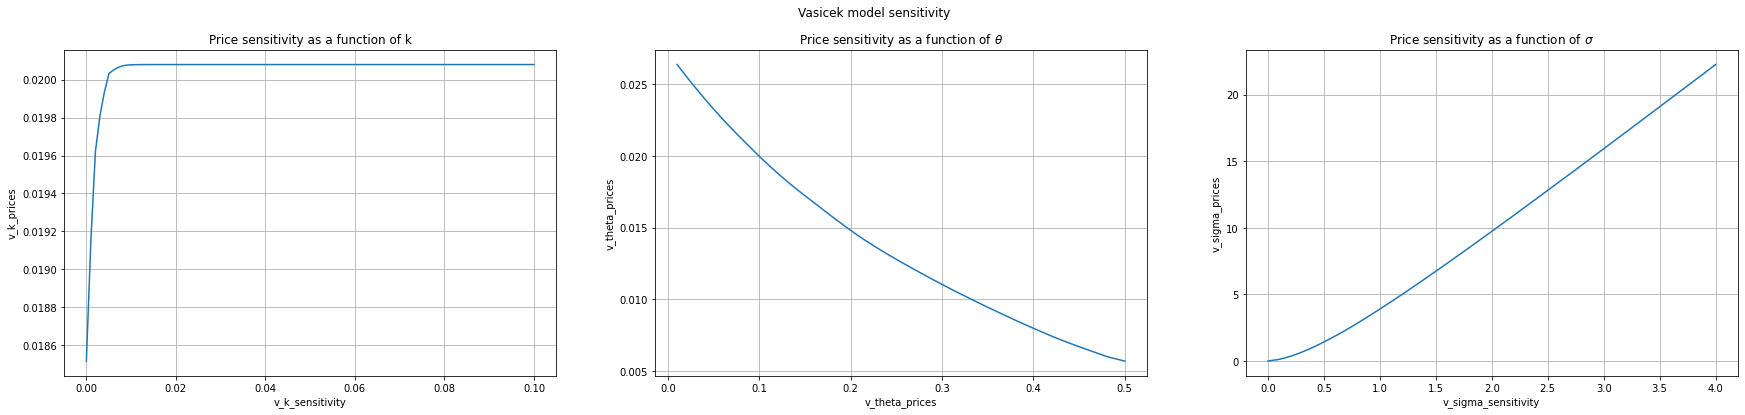

In [22]:
n = 100

v_k_sensitivity = np.linspace(0.0001, 0.10, n)
v_theta_sensitivity = np.linspace(0.01, 0.5, n)
v_sigma_sensitivity = np.linspace(0.0001, 4, n)
v_k_prices = []
v_theta_prices = []
v_sigma_prices = []

fig, ax = plt.subplots(1, 3, figsize=(30, 6))

for i in tqdm(range(len(v_k_sensitivity))):
  # for v_k
  vasicek_price = VModel(v_k=v_k_sensitivity[i], v_theta=v_theta, v_sigma=v_sigma, v_r0=v_r0, v_K=v_K, v_dt=v_dt, v_N=v_N, forward_rates=forward_rates)
  v_k_prices.append(vasicek_price.generate_vasicek_price())

  # for v_theta
  vasicek_price = VModel(v_k=v_k, v_theta=v_theta_sensitivity[i], v_sigma=v_sigma, v_r0=v_r0, v_K=v_K, v_dt=v_dt, v_N=v_N, forward_rates=forward_rates)
  v_theta_prices.append(vasicek_price.generate_vasicek_price())

  # for v_sigma
  vasicek_price = VModel(v_k=v_k, v_theta=v_theta, v_sigma=v_sigma_sensitivity[i], v_r0=v_r0, v_K=v_K, v_dt=v_dt, v_N=v_N, forward_rates=forward_rates)
  v_sigma_prices.append(vasicek_price.generate_vasicek_price())

fig.suptitle('Vasicek model sensitivity')

ax[0].plot(v_k_sensitivity, v_k_prices)
ax[0].set_title('Price sensitivity as a function of k')
ax[0].set(xlabel='v_k_sensitivity', ylabel='v_k_prices')
ax[0].grid()

ax[1].plot(v_theta_sensitivity, v_theta_prices)
ax[1].set_title(r'Price sensitivity as a function of $\theta$')
ax[1].set(xlabel='v_theta_prices', ylabel='v_theta_prices')
ax[1].grid()

ax[2].plot(v_sigma_sensitivity, v_sigma_prices)
ax[2].set_title(r'Price sensitivity as a function of $\sigma$')
ax[2].set(xlabel='v_sigma_sensitivity', ylabel='v_sigma_prices')
ax[2].grid()

plt.show()

In [23]:
class CIRModel():
  def __init__(self, cir_alpha, cir_beta, cir_sigma, cir_r0, cir_K, cir_dt, cir_N, forward_rates):
    self.cir_alpha = cir_alpha
    self.cir_beta = cir_beta
    self.cir_sigma = cir_sigma
    self.cir_r0 = cir_r0
    self.cir_K = cir_K
    self.cir_dt = cir_dt
    self.cir_N = cir_N
    self.forward_rates = forward_rates
    self.cir_dx = np.sqrt(3*self.cir_dt*(self.cir_sigma/2)**2)

  def calc_self_zeros(self):
    zeros = np.zeros(self.cir_N)

    for i in range(self.cir_N):
      if i == 0:
        zeros[i] = np.exp(-self.forward_rates[i]*self.cir_dt)
      else:
        zeros[i] = zeros[i-1]*np.exp(-self.forward_rates[i]*self.cir_dt)

    return zeros

  def get_probs_values(self):
    pu = []
    pm = []
    pd = []

    for i in range(1, len(self.help_data)+1):
      pu.append(1/6+(self.help_data[-i]**2)/2+(self.help_data[-i])/2)
      pm.append(2/3-self.help_data[-i]**2)
      pd.append(1/6+(self.help_data[-i]**2)/2-(self.help_data[-i])/2)

    pu = pu[::-1]
    pm = pm[::-1]
    pd = pd[::-1]

    return pu, pm, pd

  def generate_tree(self):
    mid = np.zeros(self.cir_N + 1)
    interest = []
    exp = []

    for i in range(self.cir_N + 1):
      if i == 0:
        mid[i] = np.sqrt(self.cir_r0)
        interest.append(np.array([mid[i]]))
        exp.append(np.exp(-interest[i]*self.cir_dt))
      else:
        mid[i] = mid[i-1]+self.cir_dt*((self.cir_alpha/2-(self.cir_sigma**2)/8)/mid[i-1]-self.cir_beta/2*mid[i-1]) # exp value
        interest.append(np.abs(mid[i]+self.cir_dx*np.linspace(-i,i,2*i+1))) # avoid negative values for rates
        exp.append(np.exp(-(interest[i]**2)*self.cir_dt))

    return interest, exp, mid

  def generate_help_data(self):
    help_data = []

    for i in range(1, self.cir_N+1):
      m = self.interest[-i][1:-1]
      s = self.mid[-i-1]+self.cir_dx*np.linspace(-self.cir_N+i, self.cir_N-i, (self.cir_N-i)*2+1)
      s[np.abs(s)<=0.04] = np.sign(s[np.abs(s)<=0.04])*np.sqrt(np.abs(s[np.abs(s)<=0.04]))
      p = self.interest[-i-1]+self.cir_dt*((self.cir_alpha/2-(self.cir_sigma**2)/8)/s-self.cir_beta/2*self.interest[-i-1])

      help_data.append((p-m)/self.cir_dx)

    help_data = help_data[::-1]

    return help_data

  def generate_arrow_debreu_data(self):
        arrow_debreu = []
        phi = np.zeros(self.cir_N)

        for i in range(self.cir_N):
            if i == 0:
                arrow_debreu.append(np.array([1.0]))
                phi[i] = (np.log(arrow_debreu[i] * np.exp(-self.cir_r0*self.cir_dt)) -
                          np.log(self.zeros[i]))/self.cir_dt
            elif i == 1:
                arrow_debreu.append(np.array([1 * self.pd[0] * np.exp(-(self.cir_r0 + phi[0])*self.cir_dt), 1 * self.pm[0]
                                    * np.exp(-(self.cir_r0 + phi[0])*self.cir_dt), 1 * self.pu[0] * np.exp(-(self.cir_r0 + phi[0])*self.cir_dt)]))
                phi[i] = (np.log(np.dot(self.exp[i], arrow_debreu[i])) -
                          np.log(self.zeros[i]))/self.cir_dt
            else:
                data = np.zeros(i * 2 + 1)
                for j in range(1, i*2 + 2):
                    if j == 1:
                        data[j - 1] = arrow_debreu[i - 1][0] * self.pd[i - 1][0] * \
                            np.exp(-(self.interest_square[i - 1]
                                     [0] + phi[i - 1]) * self.cir_dt)
                    elif j == 2:
                        data[j - 1] = (arrow_debreu[i - 1][1] * self.pd[i - 1][1] * np.exp(-(self.interest_square[i - 1][1] + phi[i - 1]) * self.cir_dt) +
                                      arrow_debreu[i - 1][0] * self.pm[i - 1][0] * np.exp(-(self.interest_square[i - 1][0] + phi[i - 1]) * self.cir_dt))
                    elif j == i*2:
                        data[j - 1] = (arrow_debreu[i - 1][-1] * self.pm[i - 1][-1] * np.exp(-(self.interest_square[i - 1][-1] + phi[i - 1]) * self.cir_dt) +
                                      arrow_debreu[i - 1][-2] * self.pu[i - 1][-2] * np.exp(-(self.interest_square[i - 1][-2] + phi[i - 1]) * self.cir_dt))
                    elif j == i*2 + 1:
                        data[j - 1] = arrow_debreu[i - 1][-1] * self.pu[i - 1][-1] * \
                            np.exp(-(self.interest_square[i - 1]
                                     [-1] + phi[i - 1]) * self.cir_dt)
                    else:
                        data[j - 1] = (arrow_debreu[i - 1][j - 3] * self.pu[i - 1][j - 3] * np.exp(-(self.interest_square[i - 1][j - 3] + phi[i - 1]) * self.cir_dt) +
                                      arrow_debreu[i - 1][j - 2] * self.pm[i - 1][j - 2] * np.exp(-(self.interest_square[i - 1][j - 2] + phi[i - 1]) * self.cir_dt) +
                                      arrow_debreu[i - 1][j - 1] * self.pd[i - 1][j - 1] * np.exp(-(self.interest_square[i - 1][j - 1] + phi[i - 1]) * self.cir_dt))
                arrow_debreu.append(data)
                phi[i] = (np.log(np.dot(self.exp[i], arrow_debreu[i])) -
                          np.log(self.zeros[i]))/self.cir_dt
        return arrow_debreu, phi

  def generate_interest_square(self):
        interest_square = []

        for i in self.interest:
            interest_square.append(i**2)

        return interest_square

  def generate_interest_with_phi(self):
        interest_phi = []

        for i in range(len(self.phi)):
            interest_phi.append(self.interest_square[i] + self.phi[i])

        return interest_phi

  def generate_price(self):
        price_data = []

        for i in range(1, len(self.interest_phi) + 1):
            if i == 1:
                price_data.append((self.interest_phi[-i] - self.cir_K) * self.cir_dt)
            elif i >= 3 and i <= 4:
                data = np.zeros(self.interest_phi[-i].shape[0])
                for j in range(self.interest_phi[-i].shape[0]):
                    data[j] = np.exp(-self.forward_rates[-i] * self.cir_dt) * (self.pu[-i][j] * (price_data[i - 2][j + 2] + self.cir_dt * (self.interest_phi[-i + 1][j + 2] - self.cir_K)) + self.pm[-i][j] * (
                        price_data[i - 2][j + 1] + self.cir_dt * (self.interest_phi[-i + 1][j + 1] - self.cir_K)) + self.pd[-i][j] * (price_data[i - 2][j] + self.cir_dt * (self.interest_phi[-i + 1][j] - self.cir_K)))
                price_data.append(data)
            elif i >= 5 and i <= 11:
                data = np.zeros(self.interest_phi[-i].shape[0])
                for j in range(self.interest_phi[-i].shape[0]):
                    data[j] = max(np.exp(-self.forward_rates[-i] * self.cir_dt) * (self.pu[-i][j] * (price_data[i - 2][j + 2] + self.cir_dt * (self.interest_phi[-i + 1][j + 2] - self.cir_K)) + self.pm[-i][j] * (
                        price_data[i - 2][j + 1] + self.cir_dt * (self.interest_phi[-i + 1][j + 1] - self.cir_K)) + self.pd[-i][j] * (price_data[i - 2][j] + self.cir_dt * (self.interest_phi[-i + 1][j] - self.cir_K))), 0)
                price_data.append(data)
            else:
                data = np.zeros(self.interest_phi[-i].shape[0])
                for j in range(self.interest_phi[-i].shape[0]):
                    data[j] = np.exp(-self.forward_rates[-i] * self.cir_dt) * (self.pu[-i][j] * price_data[i - 2][j + 2] + self.pm[-i][j] * price_data[i - 2][j + 1] + self.pd[-i][j] * price_data[i - 2][j])
                price_data.append(data)

        return price_data
  

  def generate_cir_price(self):
    self.interest, self.exp, self.mid = self.generate_tree()
    self.help_data = self.generate_help_data()
    self.pu, self.pm, self.pd = self.get_probs_values()
    self.zeros = self.calc_self_zeros()
    self.interest_square = self.generate_interest_square()
    self.arrow_debreu, self.phi = self.generate_arrow_debreu_data()
    self.interest_phi = self.generate_interest_with_phi()
    self.price_data = self.generate_price()

    return self.price_data[-1][0]

In [24]:
# CIR inputs
cir_alpha = 0.45 / 100
cir_beta = 10 / 100
cir_sigma = 4.47 / 100
cir_r0 = 4.6 / 100
cir_K = 4.7 / 100
cir_dt = 0.5
cir_N = len(forward_rates)

In [25]:
cir_price = CIRModel(cir_alpha=cir_alpha, cir_beta=cir_beta, cir_sigma=cir_sigma, cir_r0=cir_r0, cir_K=cir_K, cir_dt=cir_dt, cir_N=cir_N, forward_rates=forward_rates)
cir_price.generate_cir_price()

0.01932599820562219

# **CIR Model Sensitivity Tests**

100%|██████████| 100/100 [00:01<00:00, 52.16it/s]


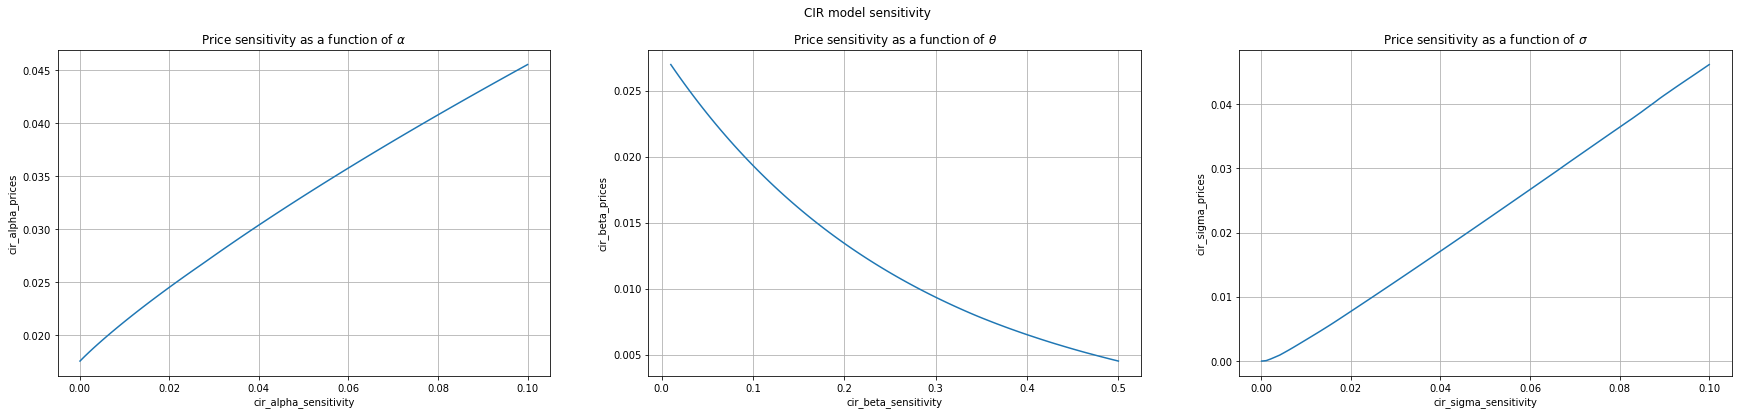

In [26]:
n = 100

cir_alpha_sensitivity = np.linspace(0.0001, 0.10, n)
cir_beta_sensitivity = np.linspace(0.01, 0.5, n)
cir_sigma_sensitivity = np.linspace(0.0001, 0.1, n)
cir_alpha_prices = []
cir_beta_prices = []
cir_sigma_prices = []

fig, ax = plt.subplots(1, 3, figsize=(30, 6))

for i in tqdm(range(len(cir_alpha_sensitivity))):
  # for cir_k
  cir_price =  CIRModel(cir_alpha=cir_alpha_sensitivity[i], cir_beta=cir_beta, cir_sigma=cir_sigma, cir_r0=cir_r0, cir_K=cir_K, cir_dt=cir_dt, cir_N=cir_N, forward_rates=forward_rates)
  cir_alpha_prices.append(cir_price.generate_cir_price())

  # for cir_theta
  cir_price =  CIRModel(cir_alpha=cir_alpha, cir_beta=cir_beta_sensitivity[i], cir_sigma=cir_sigma, cir_r0=cir_r0, cir_K=cir_K, cir_dt=cir_dt, cir_N=cir_N, forward_rates=forward_rates)
  cir_beta_prices.append(cir_price.generate_cir_price())

  # for cir_sigma
  cir_price =  CIRModel(cir_alpha=cir_alpha, cir_beta=cir_beta, cir_sigma=cir_sigma_sensitivity[i], cir_r0=cir_r0, cir_K=cir_K, cir_dt=cir_dt, cir_N=cir_N, forward_rates=forward_rates)
  cir_sigma_prices.append(cir_price.generate_cir_price())

fig.suptitle('CIR model sensitivity')

ax[0].plot(cir_alpha_sensitivity, cir_alpha_prices)
ax[0].set_title(r'Price sensitivity as a function of $\alpha$')
ax[0].set(xlabel='cir_alpha_sensitivity', ylabel='cir_alpha_prices')
ax[0].grid()

ax[1].plot(cir_beta_sensitivity, cir_beta_prices)
ax[1].set_title(r'Price sensitivity as a function of $\theta$')
ax[1].set(xlabel='cir_beta_sensitivity', ylabel='cir_beta_prices')
ax[1].grid()

ax[2].plot(cir_sigma_sensitivity, cir_sigma_prices)
ax[2].set_title(r'Price sensitivity as a function of $\sigma$')
ax[2].set(xlabel='cir_sigma_sensitivity', ylabel='cir_sigma_prices')
ax[2].grid()

plt.show()

# **Joint Tests for r0 and K**

100%|██████████| 100/100 [00:02<00:00, 44.05it/s]


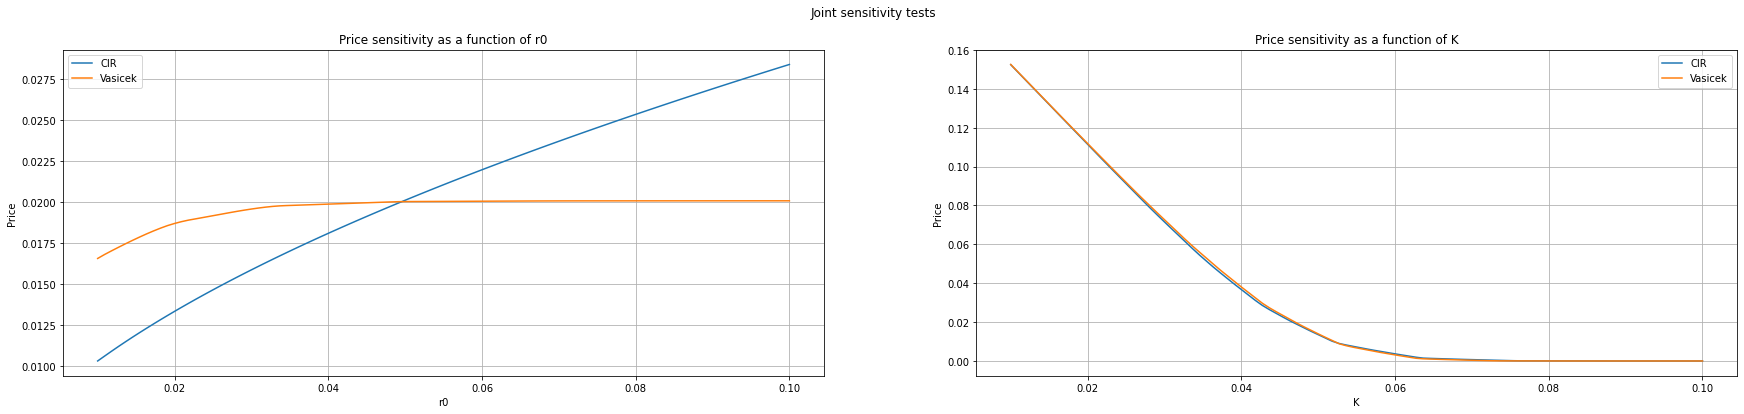

In [27]:
r0_sensitivity = np.linspace(0.01, 0.1, n)
K_sensitivity = np.linspace(0.01, 0.1, n)

CIR_r0 = []
V_r0 = []

CIR_K = []
V_K =[]

fig, ax = plt.subplots(1, 2, figsize=(30, 6))

for i in tqdm(range(len(r0_sensitivity))):
  # r0
  cir_price =  CIRModel(cir_alpha=cir_alpha, cir_beta=cir_beta, cir_sigma=cir_sigma, cir_r0=r0_sensitivity[i], cir_K=cir_K, cir_dt=cir_dt, cir_N=cir_N, forward_rates=forward_rates)
  vasicek_price = VModel(v_k=v_k, v_theta=v_theta, v_sigma=v_sigma, v_r0=r0_sensitivity[i], v_K=v_K, v_dt=v_dt, v_N=v_N, forward_rates=forward_rates)

  CIR_r0.append(cir_price.generate_cir_price())
  V_r0.append(vasicek_price.generate_vasicek_price())

  # K
  cir_price =  CIRModel(cir_alpha=cir_alpha, cir_beta=cir_beta, cir_sigma=cir_sigma, cir_r0=cir_r0, cir_K=K_sensitivity[i], cir_dt=cir_dt, cir_N=cir_N, forward_rates=forward_rates)
  vasicek_price = VModel(v_k=v_k, v_theta=v_theta, v_sigma=v_sigma, v_r0=v_r0, v_K=K_sensitivity[i], v_dt=v_dt, v_N=v_N, forward_rates=forward_rates)

  CIR_K.append(cir_price.generate_cir_price())
  V_K.append(vasicek_price.generate_vasicek_price())

fig.suptitle('Joint sensitivity tests')

ax[0].plot(r0_sensitivity, CIR_r0, label='CIR')
ax[0].plot(r0_sensitivity, V_r0, label='Vasicek')
ax[0].legend(loc='best')
ax[0].set_title(r'Price sensitivity as a function of r0')
ax[0].set(xlabel='r0', ylabel='Price')
ax[0].grid()

ax[1].plot(K_sensitivity, CIR_K, label='CIR')
ax[1].plot(K_sensitivity, V_K, label='Vasicek')
ax[1].legend(loc='best')
ax[1].set_title(r'Price sensitivity as a function of K')
ax[1].set(xlabel='K', ylabel='Price')
ax[1].grid()

plt.show()